In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.3.0+cu121
torchvision version: 0.18.0+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [3]:
device='cuda' if torch.cuda.is_available() else 'cpu'
#torch.set_default_device(device)
device

'cuda'

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [5]:
train_dir=image_path/'train'
test_dir=image_path/'test'


In [6]:
img_size=224

manual_transform=transforms.Compose([
   transforms.Resize((img_size,img_size)),
   transforms.ToTensor(), 
])

manual_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [7]:
BATCH_SIZE = 8 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transform, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1ddfaec38b0>,
 ['pizza', 'steak', 'sushi'])

In [8]:
image_batch, label_batch=next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

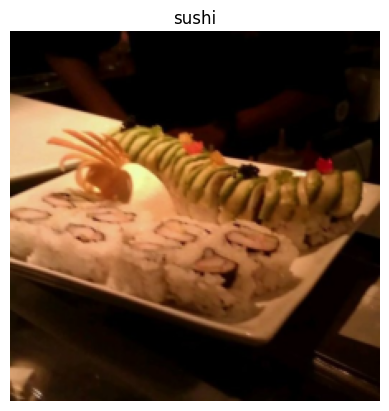

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)

In [10]:
height=224
width=224
color_channels=3
patch_size=16

number_of_patches=int((height*width)/patch_size**2)
number_of_patches

196

In [11]:
embedding_layer_input_shape=(height,width,color_channels)

embedding_layer_output_shape=(number_of_patches,patch_size**2*color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


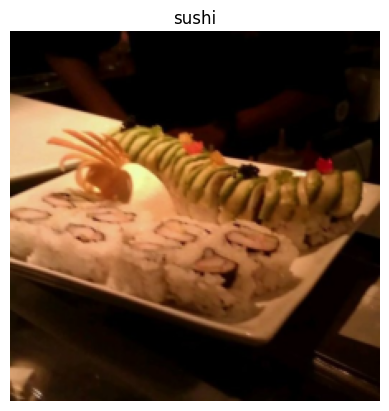

In [12]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

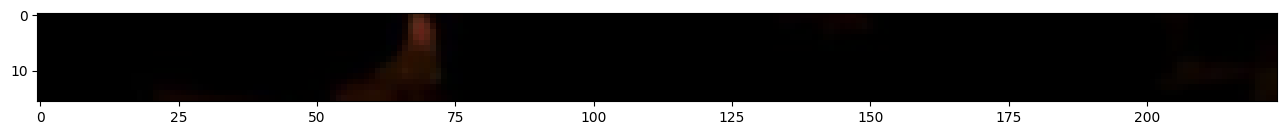

In [13]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


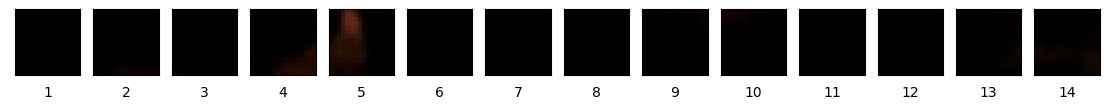

In [14]:
num_patches=img_size/patch_size
assert img_size % patch_size ==0 ,"Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch in enumerate(range(0,img_size,patch_size)):
    axs[i].imshow(image_permuted[:patch_size,patch:patch+patch_size,:])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])    


Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


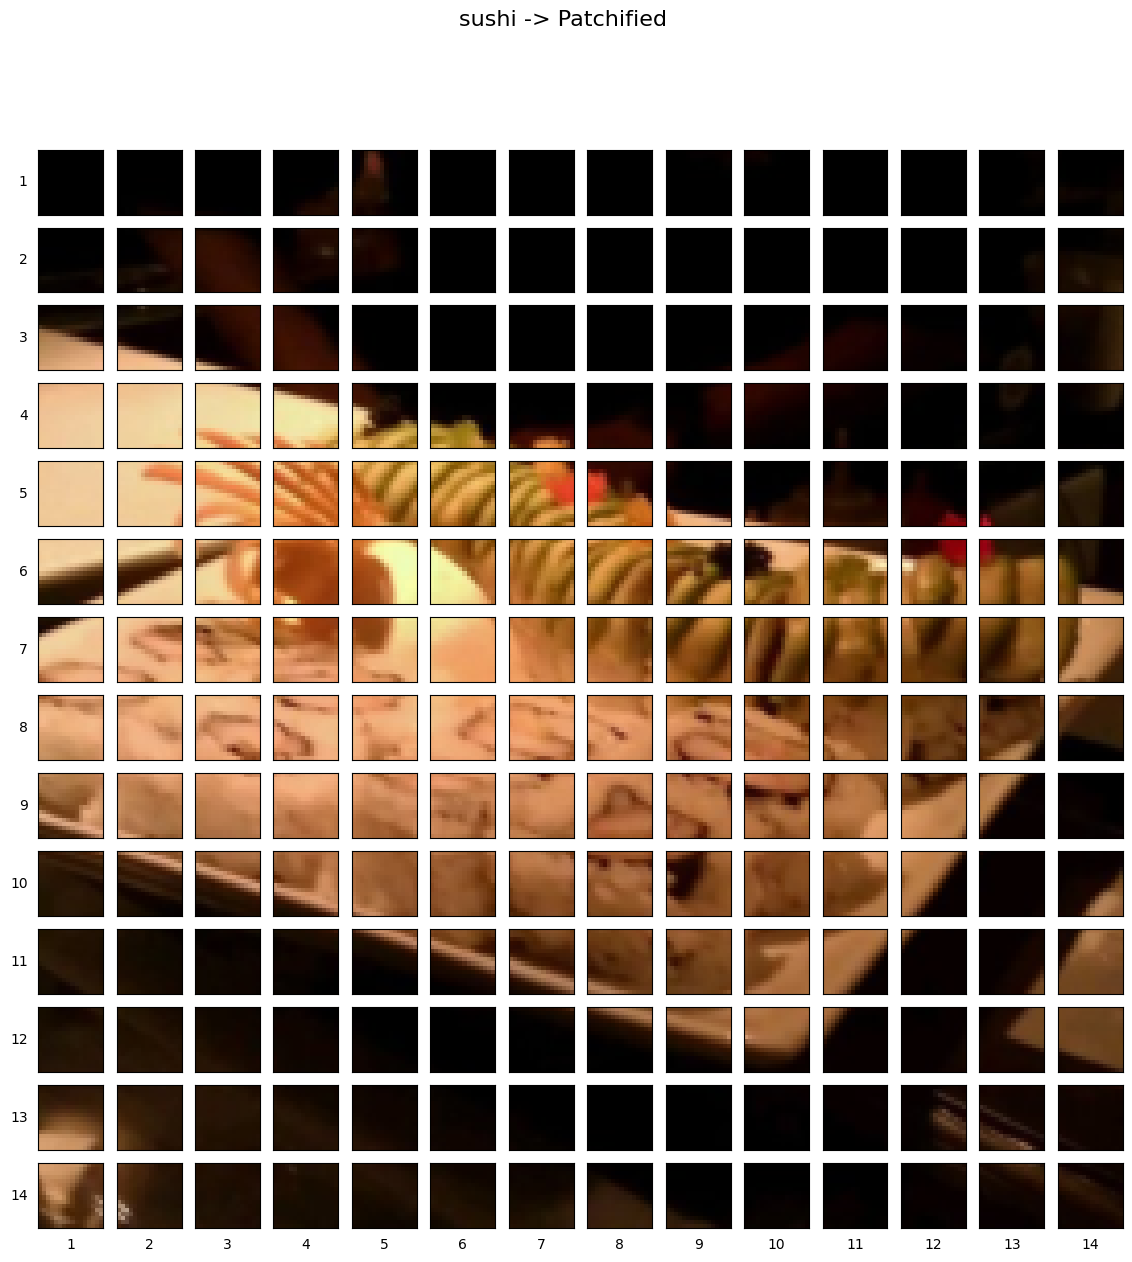

In [15]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [16]:
from torch import nn

patch_size=16

conv2d=nn.Conv2d(in_channels=3,
                 out_channels=768,
                 kernel_size=patch_size,
                 stride=patch_size,
                 padding=0,
                )

In [17]:

image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [10, 418, 614, 216, 646]


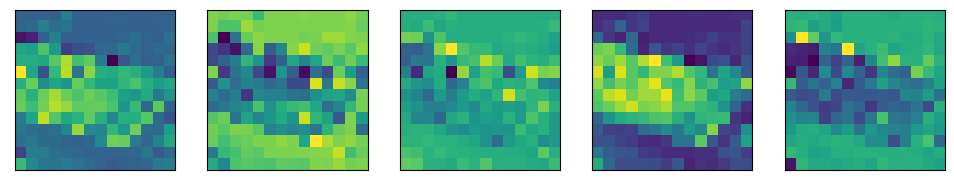

In [18]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [19]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-2.0204e-02, -2.1741e-02, -2.0685e-02, -3.4231e-02,  5.1765e-03,
           -2.0204e-02, -2.0204e-02, -2.0204e-02, -1.7241e-02, -1.1726e-02,
           -2.0204e-02, -2.0204e-02, -2.2087e-02, -1.2095e-02],
          [-2.0019e-02,  4.6024e-02,  3.1503e-02,  1.4595e-02,  1.9391e-02,
           -2.0204e-02, -2.0204e-02, -2.0204e-02, -2.0204e-02, -2.0204e-02,
           -2.0204e-02, -2.0204e-02, -1.4189e-02, -1.2096e-02],
          [-1.8557e-01, -8.8465e-02,  1.0322e-01,  3.9014e-02, -1.3217e-02,
           -2.0204e-02, -2.0204e-02, -2.0204e-02, -1.8138e-02, -3.8066e-02,
            1.9161e-02, -1.5643e-02, -3.7074e-02,  1.1292e-02],
          [ 7.3840e-02,  7.5737e-02,  7.9744e-02, -8.6849e-02, -2.2138e-01,
           -5.4291e-02, -1.6980e-02, -3.7285e-03,  3.2633e-02,  2.5635e-02,
            1.9512e-04, -1.6686e-02, -4.4638e-03,  2.0734e-02],
          [ 8.6820e-02,  8.4820e-02,  1.6131e-01,  2.5528e-01,  3.0645e-01,
            2.2093e-01,  1.6909e-01,  1.1255e-03, -6.5291e-0

In [20]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


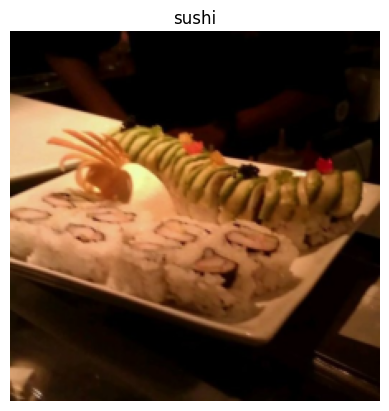

In [21]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [22]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


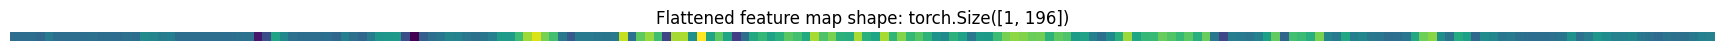

In [23]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [24]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels:int=3,patch_size:int=3,embedding_dim:int=768):
        super().__init__()
        self.patcher=nn.Conv2d(in_channels=in_channels,
                               out_channels=embedding_dim,
                               stride=patch_size,
                               kernel_size=patch_size,
                               padding=0)
        self.flatten=nn.Flatten(start_dim=2,end_dim=3)
        
    def forward(self,x):
        image_resolution=x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}"
        
        x_patched=self.patcher(x)
        x_flattened=self.flatten(x_patched)
        
        return x_flattened.permute(0,2,1)
        

In [25]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [26]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
         [-0.0255, -0.0154, -0.0322,  ...,  0.0081, -0.0076,  0.0118],
         [-0.0216, -0.0118, -0.0359,  ...,  0.0115, -0.0010,  0.0017],
         ...,
         [-0.0424,  0.0009, -0.0341,  ...,  0.0252, -0.0213, -0.0059],
         [-0.0518,  0.0109, -0.0231,  ...,  0.0456, -0.0472, -0.0239],
         [-0.1175, -0.0093, -0.0219,  ...,  0.0307, -0.0336, -0.0033]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [27]:
batch_size=patch_embedded_image.shape[0]
embedding_dimension=patch_embedded_image.shape[-1]

class_token=nn.Parameter(torch.randn(batch_size,1,embedding_dimension),requires_grad=True)

print(class_token[:,:,:10])

print(class_token.shape)

tensor([[[ 0.5436, -0.4700, -1.2133,  0.8982,  1.3769,  0.4988, -0.5628,
           0.2139,  0.5812, -1.1086]]], grad_fn=<SliceBackward0>)
torch.Size([1, 1, 768])


In [28]:
patch_embedded_image_with_class_embedding=torch.cat((class_token,patch_embedded_image),dim=1)

patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [29]:
embedding_dimension=patch_embedded_image_with_class_embedding.shape[2]
number_of_patches=int((height*width)/patch_size**2)

position_embedding=nn.Parameter(torch.randn(1,number_of_patches+1,embedding_dimension),requires_grad=True)

print(position_embedding[:, :10, :10])
position_embedding.shape


tensor([[[-1.0264, -2.4631,  0.1703, -0.3792, -0.2175,  0.3899, -1.8656,
          -0.0395,  0.3717,  0.1368],
         [-0.6950,  0.7188, -1.1410, -0.5563,  0.3425, -0.7327, -0.0052,
          -0.8103, -0.7187, -0.1611],
         [-1.5855, -0.3176, -1.4012, -1.3915, -0.1853,  0.6562,  0.5200,
           0.0703,  0.2820,  0.9959],
         [-0.3998, -0.2792, -0.3343, -0.3861,  0.9294, -0.0130, -0.1827,
          -0.6484,  1.7424, -0.8374],
         [-0.5009,  1.0029,  0.7872,  0.1788, -0.4658,  0.4155,  0.2546,
          -0.0953,  0.1655, -1.2776],
         [ 1.6989,  0.4772,  0.1792, -0.2499, -1.0494, -0.4248,  1.1466,
          -1.3408,  1.0880, -0.4174],
         [-0.1335,  0.9364,  0.5888,  0.9429, -0.4862, -0.1939,  0.7016,
           0.3350,  0.2557,  0.2404],
         [-0.4736, -1.2536,  1.6649,  0.1761,  0.0667, -1.2113, -0.3906,
           0.5781, -0.6048, -0.3013],
         [ 0.6837, -0.4015, -1.0961, -3.0875, -0.3553,  0.6072, -0.3472,
           1.8270, -0.3787, -0.2578],
 

torch.Size([1, 197, 768])

In [30]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.4828, -2.9331, -1.0430,  ..., -0.3104,  1.8254,  0.7019],
         [-0.7138,  0.7075, -1.1721,  ..., -0.3047, -2.2254, -0.6889],
         [-1.6110, -0.3330, -1.4333,  ...,  1.8064,  0.5001,  0.0433],
         ...,
         [ 1.2431,  0.8312,  0.1156,  ..., -0.4499,  1.2451,  0.6699],
         [-0.0924, -0.5062, -0.3720,  ..., -0.4466,  0.3030,  1.3232],
         [-0.3629, -0.0140,  1.4766,  ..., -0.3768,  1.5450, -0.3313]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]



Setting the patch size (we'll use 16 as it's widely used throughout the paper and for ViT-Base).
Getting a single image, printing its shape and storing its height and width.
Adding a batch dimension to the single image so it's compatible with our PatchEmbedding layer.
Creating a PatchEmbedding layer (the one we made in section 4.5) with a patch_size=16 and embedding_dim=768 (from Table 1 for ViT-Base).
Passing the single image through the PatchEmbedding layer in 4 to create a sequence of patch embeddings.
Creating a class token embedding like in section 4.6.
Prepending the class token embedding to the patch embeddings created in step 5.
Creating a position embedding like in section 4.7.
Adding the position embedding to the class token and patch embeddings created in step 7.

In [31]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


In [32]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                embedding_dim:int=768,
                num_heads:int=12,
                attn_dropout:float=0, 
                ) -> None:
        super().__init__()
        
        self.layer_norm=nn.LayerNorm(normalized_shape=embedding_dim)
        self.multihead_attn=nn.MultiheadAttention(embed_dim=embedding_dim,num_heads=num_heads,dropout=attn_dropout,batch_first=True)
        
    def forward(self,x):
        x=self.layer_norm(x)
        attn_output, _= self.multihead_attn(query=x,key=x,value=x,need_weights=False)
        return attn_output

In [33]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


In [34]:
class MLPBlock(nn.Module):
    def __init__(self,embedding_dim:int=768,mlp_size:int=3072,dropout:float=0.1):
        super().__init__()
        
        self.layer_norm=nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.mlp=nn.Sequential(
            nn.Linear(in_features=embedding_dim,out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
        
    def forward(self,x):
        x=self.layer_norm(x)
        x=self.mlp(x)
        return x

In [35]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


In [36]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,embedding_dim:int=768,num_heads:int=12,mlp_size:int=3072, mlp_dropout:float=0.1,attn_dropout:float=0):
        
        super().__init__()
        
        self.msa_block=MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,num_heads=num_heads,attn_dropout=attn_dropout)
        
        self.mlp_block=MLPBlock(embedding_dim=embedding_dim,mlp_size=mlp_size,dropout=mlp_dropout)
    
    def forward(self, x):
        x =  self.msa_block(x) + x
        x = self.mlp_block(x) + x

        return x   
    

In [37]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
# summary(model=transformer_encoder_block,
#         input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [38]:
torch_transformer_encoder_layer=nn.TransformerEncoderLayer(d_model=768,nhead=12,dim_feedforward=3072,dropout=0.1,activation='gelu',batch_first=True,norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [39]:
class ViT(nn.Module):
    def __init__(self, img_size=224, in_channels:int=3,
                 patch_size:int=16,
                 num_transformer_layers:int=32,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:int=12,
                 mlp_dropout:float=0.1,
                 embedding_dropout:float=0.1,
                 num_classes:int=1000):
        super().__init__()
        
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        
        self.num_patches=(img_size*img_size)//patch_size**2
        
        #Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding=nn.Parameter(data=torch.randn(1,1,embedding_dim), requires_grad=True)
        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),requires_grad=True)
        
        self.embedding_dropout=nn.Dropout(p=embedding_dropout)
        
        self.patch_embedding=PatchEmbedding(in_channels=in_channels,patch_size=patch_size,embedding_dim=embedding_dim)
        
        self.transformer_encoder=nn.Sequential(
            *[TransformerEncoderBlock(embedding_dim=embedding_dim,num_heads=num_heads,mlp_size=mlp_size,mlp_dropout=mlp_dropout)
              for _ in range(num_transformer_layers)]
        )
        
        self.classifier=nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,out_features=num_classes)
        )
        
        
    def forward(self,x):
        
        batch_size=x.shape[0]
        class_token=self.class_embedding.expand(batch_size,-1,-1)
        x=self.patch_embedding(x)
        x=torch.cat((class_token,x),dim=1)
        x=self.position_embedding+x
        x=self.embedding_dropout(x)
        x=self.transformer_encoder(x)
        x=self.classifier(x[:,0])
        return x
        
        

In [40]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [41]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.4829, -0.1017, -0.7261]], grad_fn=<AddmmBackward0>)

In [42]:
from torchinfo import summary

# # Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
# summary(model=vit,
#         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )

In [43]:
from going_modular.going_modular import engine

optimizer=torch.optim.Adam(params=vit.parameters(),lr=3e-3,betas=(0.9,0.999),weight_decay=0.3)

loss_fn=torch.nn.CrossEntropyLoss()

set_seeds()

# results=engine.train(
#     model=vit,
#     train_dataloader=train_dataloader,
#     test_dataloader=test_dataloader,
#     optimizer=optimizer,
#     loss_fn=loss_fn,
#     epochs=5,
#     device=device
# )

In [44]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

NameError: name 'results' is not defined

In [45]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [46]:
pretrained_vit_weights=torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit=torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad=False
    
set_seeds()

pretrained_vit.heads=nn.Linear(in_features=768,out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to C:\Users\Yuval/.cache\torch\hub\checkpoints\vit_b_16-c867db91.pth
100%|██████████| 330M/330M [01:32<00:00, 3.76MB/s] 


In [47]:
# # Print a summary using torchinfo (uncomment for actual output)
# summary(model=pretrained_vit,
#         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )

In [48]:
from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [49]:
# Setup train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [50]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [51]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,test_dir=test_dir,transform=pretrained_vit_transforms,batch_size=32)



In [52]:
from going_modular.going_modular import engine

optimizer=torch.optim.Adam(params=pretrained_vit.parameters(),lr=1e-3)

loss_fn=torch.nn.CrossEntropyLoss()

set_seeds()

pretrained_vit_results=engine.train(
    model=pretrained_vit,
    train_dataloader=train_dataloader_pretrained,
    test_dataloader=test_dataloader_pretrained,
    optimizer=optimizer,
    epochs=10,
    loss_fn=loss_fn,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\Yuval\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


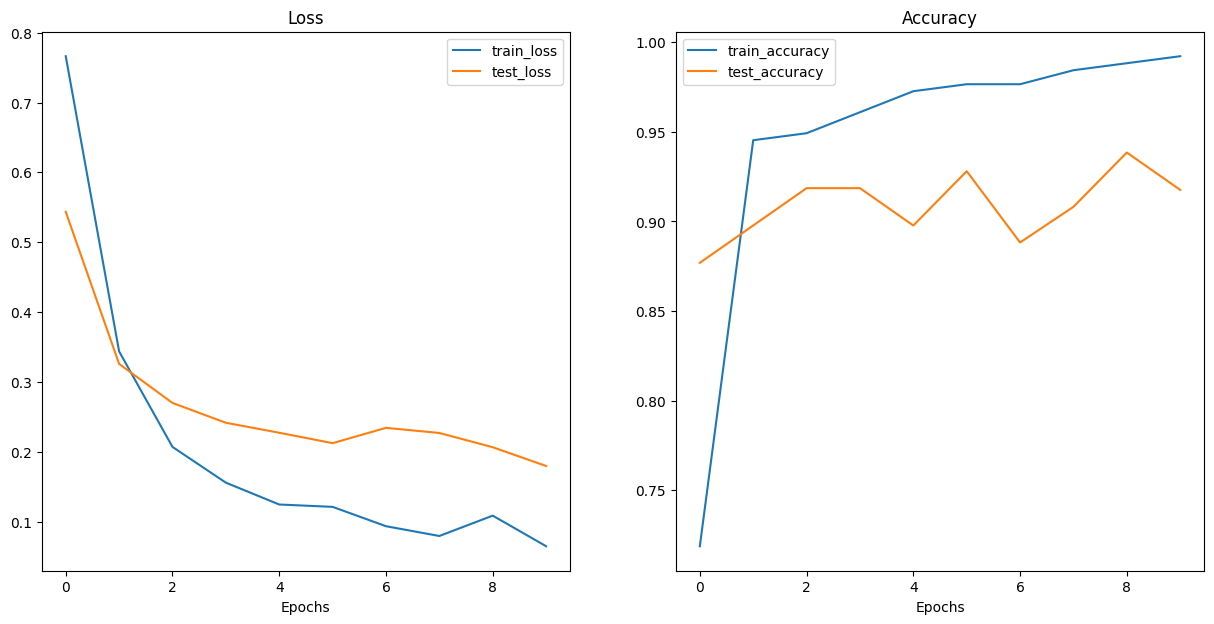

In [53]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [54]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models\08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [55]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


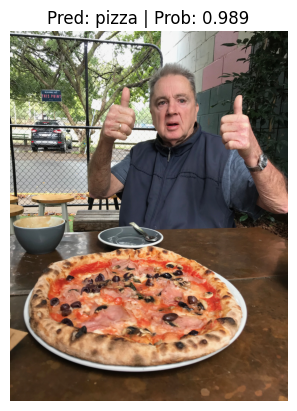

In [56]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)